# Model Evaluation and Refinement

## Objectives

After completing this notebook you will be able to:

- Build and evaluate linear regression models
- Identify overfitting and underfitting
- Use cross-validation and grid search
- Apply Ridge regression for regularization

# Import Required Libraries
Import the necessary libraries for data analysis and modeling.

In [138]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error

# Load the Dataset
We will load the cleaned automobile dataset and preview it to ensure it looks correct.

In [139]:
data_path = r"f:\\projects\\car_pricing\\data\\clean_df.csv"
df = pd.read_csv(data_path)
print(f"Shape: {df.shape}")
df.head()

Shape: (201, 17)


,symboling,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price,city-L/100km
0,3,122,88.6,0.8111,0.8903,0.8161,2548,130,3.47,2.68,9.0,111,5000.0,21,8.7037,13495.0,11.1905
1,3,122,88.6,0.8111,0.8903,0.8161,2548,130,3.47,2.68,9.0,111,5000.0,21,8.7037,16500.0,11.1905
2,1,122,94.5,0.8227,0.9097,0.8763,2823,152,2.68,3.47,9.0,154,5000.0,19,9.0385,16500.0,12.3684
3,2,164,99.8,0.8486,0.9194,0.9080,2337,109,3.19,3.40,10.0,102,5500.0,24,7.8333,13950.0,9.7917
4,2,164,99.4,0.8486,0.9222,0.9080,2824,136,3.19,3.40,8.0,115,5500.0,18,10.6818,17450.0,13.0556


# Helper Plotting Functions
We'll define small helper functions for consistent visuals used later.

In [140]:
def DistributionPlot(RedFunction, BlueFunction, RedName, BlueName, Title, figsize=(12, 10)):
    plt.figure(figsize=figsize)
    ax1 = sns.kdeplot(RedFunction, color="r", label=RedName)
    ax2 = sns.kdeplot(BlueFunction, color="b", label=BlueName, ax=ax1)
    plt.title(Title)
    plt.xlabel('Price')
    plt.ylabel('Proportion of Cars')
    plt.legend()
    plt.show()


def PollyPlot(xtrain, xtest, y_train, y_test, lr, poly_transform, degree):
    plt.figure(figsize=(12, 8))
    xs = np.arange(min(xtrain.min(), xtest.min()), max(xtrain.max(), xtest.max()), 0.1)
    ys = lr.predict(poly_transform.fit_transform(xs.reshape(-1, 1)))
    plt.plot(xtrain, y_train, 'ro', label='Training Data')
    plt.plot(xtest, y_test, 'go', label='Test Data')
    plt.plot(xs, ys, label=f'Polynomial Fit degree={degree}')
    plt.xlabel('Feature')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

# Select Target and Feature
We'll predict `price` using `horsepower` if available; otherwise we'll pick the numeric feature most correlated with price.

In [141]:
target_col = 'price'
preferred_feature = 'horsepower'

# Ensure numeric types and drop NA
df_numeric = df.select_dtypes(include=[np.number]).dropna()

if target_col not in df_numeric.columns:
    raise ValueError('Target column price not found or not numeric in the dataset.')

if preferred_feature in df_numeric.columns:
    feature_col = preferred_feature
else:
    # pick the most correlated numeric feature with price (excluding price itself)
    corr = df_numeric.corr()[target_col].drop(labels=[target_col])
    feature_col = corr.abs().idxmax()
    print(f"Using feature '{feature_col}' with correlation {corr[feature_col]:.3f} to price.")

X = df_numeric[[feature_col]].values
y = df_numeric[target_col].values

print(f"Feature: {feature_col}, X shape: {X.shape}, y shape: {y.shape}")

Feature: horsepower, X shape: (201, 1), y shape: (201,)


# Train/Test Split and Baseline Linear Regression
We'll split the data, fit a Linear Regression model, and evaluate with R^2 and RMSE.

R^2 Train: 0.642 | R^2 Test: 0.623 | RMSE Test: 6788.9


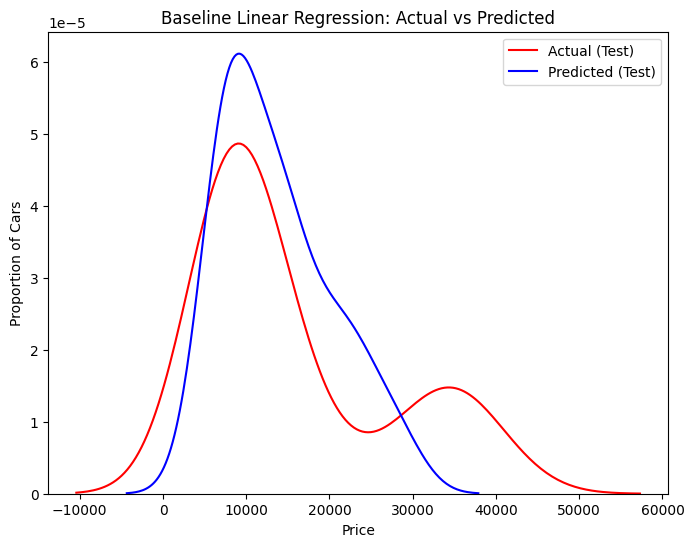

In [142]:
# Train/Test Split and Baseline Linear Regression
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Predictions
y_train_pred = lin_reg.predict(X_train)
y_test_pred = lin_reg.predict(X_test)

# Metrics
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f"R^2 Train: {r2_train:.3f} | R^2 Test: {r2_test:.3f} | RMSE Test: {rmse_test:.1f}")

# Visualization
DistributionPlot(y_test, y_test_pred, 'Actual (Test)', 'Predicted (Test)', 'Baseline Linear Regression: Actual vs Predicted', figsize=(8, 6))

# Cross-Validation
Use k-fold cross-validation to estimate out-of-sample performance.

CV R^2 scores: [ 0.738  0.56  -0.081  0.877 -0.163] | Mean: 0.386 ± 0.428


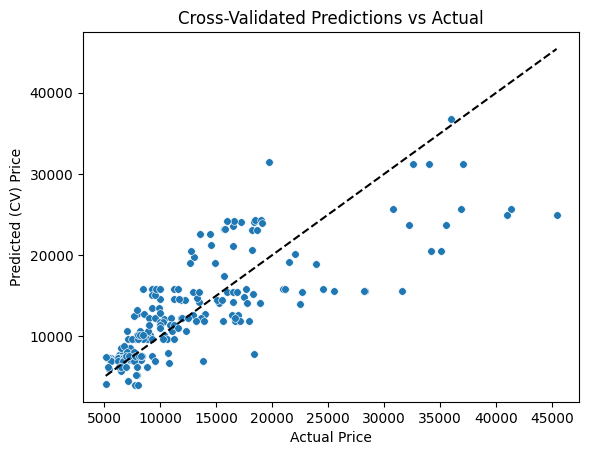

In [143]:
cv_scores = cross_val_score(lin_reg, X, y, cv=5, scoring='r2')
print(f"CV R^2 scores: {np.round(cv_scores, 3)} | Mean: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

y_cv_pred = cross_val_predict(lin_reg, X, y, cv=5)
sns.scatterplot(x=y, y=y_cv_pred, s=30)
plt.xlabel('Actual Price')
plt.ylabel('Predicted (CV) Price')
plt.title('Cross-Validated Predictions vs Actual')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--')
plt.show()

# Polynomial Regression
We expand the feature into polynomial terms and evaluate different degrees using cross-validation.

Degree 1: CV R^2 mean = 0.386 ± 0.428
Degree 2: CV R^2 mean = 0.392 ± 0.419
Degree 3: CV R^2 mean = 0.308 ± 0.470
Degree 4: CV R^2 mean = 0.161 ± 0.549
Degree 5: CV R^2 mean = -2.051 ± 4.772
Degree 6: CV R^2 mean = -13.788 ± 28.187


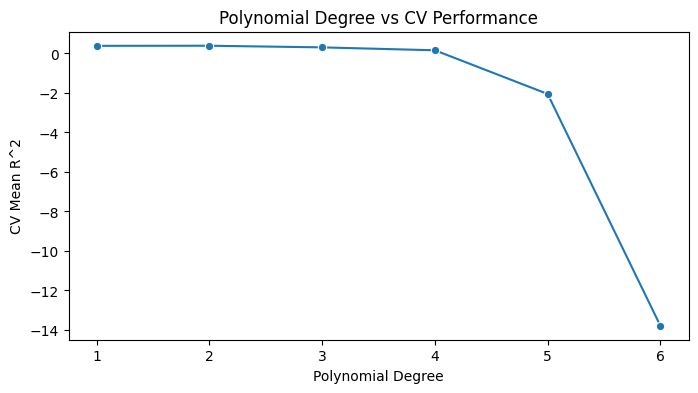

Best degree by CV: 2


In [144]:
degrees = list(range(1, 7))
cv_means = []
for d in degrees:
    model = Pipeline([('poly', PolynomialFeatures(degree=d, include_bias=False)),
                      ('lr', LinearRegression())])
    scores = cross_val_score(model, X, y, cv=5, scoring='r2')
    cv_means.append(scores.mean())
    print(f"Degree {d}: CV R^2 mean = {scores.mean():.3f} ± {scores.std():.3f}")

best_degree = degrees[int(np.argmax(cv_means))]
plt.figure(figsize=(8, 4))
sns.lineplot(x=degrees, y=cv_means, marker='o')
plt.xlabel('Polynomial Degree')
plt.ylabel('CV Mean R^2')
plt.title('Polynomial Degree vs CV Performance')
plt.show()
print(f"Best degree by CV: {best_degree}")

# Ridge Regression (Regularization)
We apply L2 regularization to reduce overfitting and tune alpha.

alpha 0.0010: CV R^2 mean = 0.392 ± 0.419
alpha 0.0032: CV R^2 mean = 0.392 ± 0.419
alpha 0.0100: CV R^2 mean = 0.392 ± 0.419
alpha 0.0316: CV R^2 mean = 0.392 ± 0.419
alpha 0.1000: CV R^2 mean = 0.392 ± 0.419
alpha 0.3162: CV R^2 mean = 0.392 ± 0.419
alpha 1.0000: CV R^2 mean = 0.392 ± 0.419
alpha 0.0316: CV R^2 mean = 0.392 ± 0.419
alpha 0.1000: CV R^2 mean = 0.392 ± 0.419
alpha 0.3162: CV R^2 mean = 0.392 ± 0.419
alpha 1.0000: CV R^2 mean = 0.392 ± 0.419
alpha 3.1623: CV R^2 mean = 0.392 ± 0.419
alpha 10.0000: CV R^2 mean = 0.392 ± 0.419
alpha 31.6228: CV R^2 mean = 0.392 ± 0.419
alpha 100.0000: CV R^2 mean = 0.392 ± 0.418
alpha 3.1623: CV R^2 mean = 0.392 ± 0.419
alpha 10.0000: CV R^2 mean = 0.392 ± 0.419
alpha 31.6228: CV R^2 mean = 0.392 ± 0.419
alpha 100.0000: CV R^2 mean = 0.392 ± 0.418
alpha 316.2278: CV R^2 mean = 0.394 ± 0.416
alpha 1000.0000: CV R^2 mean = 0.399 ± 0.411
alpha 316.2278: CV R^2 mean = 0.394 ± 0.416
alpha 1000.0000: CV R^2 mean = 0.399 ± 0.411


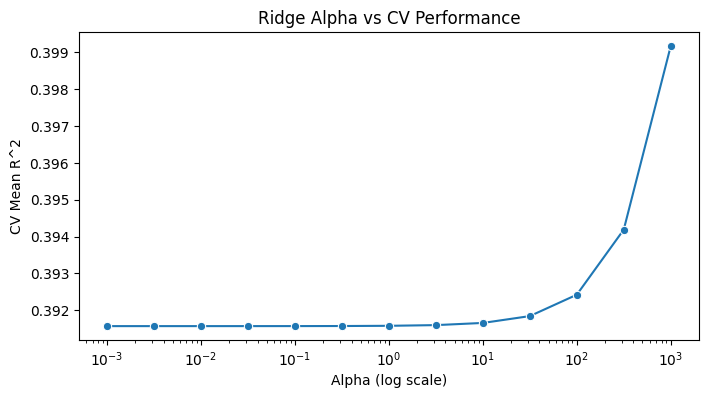

Best alpha by CV: 1000.0000


In [145]:
alphas = np.logspace(-3, 3, 13)
ridge_cv_means = []
for a in alphas:
    model = Pipeline([('poly', PolynomialFeatures(degree=int(best_degree), include_bias=False)),
                      ('ridge', Ridge(alpha=a))])
    scores = cross_val_score(model, X, y, cv=5, scoring='r2')
    ridge_cv_means.append(scores.mean())
    print(f"alpha {a:.4f}: CV R^2 mean = {scores.mean():.3f} ± {scores.std():.3f}")

best_alpha = alphas[int(np.argmax(ridge_cv_means))]
plt.figure(figsize=(8, 4))
sns.lineplot(x=alphas, y=ridge_cv_means, marker='o')
plt.xscale('log')
plt.xlabel('Alpha (log scale)')
plt.ylabel('CV Mean R^2')
plt.title('Ridge Alpha vs CV Performance')
plt.show()
print(f"Best alpha by CV: {best_alpha:.4f}")

# Hyperparameter Search (GridSearchCV)
Confirm best settings using grid search with cross-validation.

In [146]:
param_grid = {
    'poly__degree': list(range(1, 7)),
    'ridge__alpha': np.logspace(-3, 3, 13)
}
pipe = Pipeline([('poly', PolynomialFeatures(include_bias=False)),
                 ('ridge', Ridge(random_state=42))])
grid = GridSearchCV(pipe, param_grid, cv=5, scoring='r2', n_jobs=None)
grid.fit(X, y)
print(f"Best params: {grid.best_params_}")
print(f"Best CV R^2: {grid.best_score_:.3f}")

Best params: {'poly__degree': 2, 'ridge__alpha': np.float64(1000.0)}
Best CV R^2: 0.399


# Final Model: Visual Evaluation
We visualize the fitted model using the best hyperparameters to inspect fit quality and residual behavior.

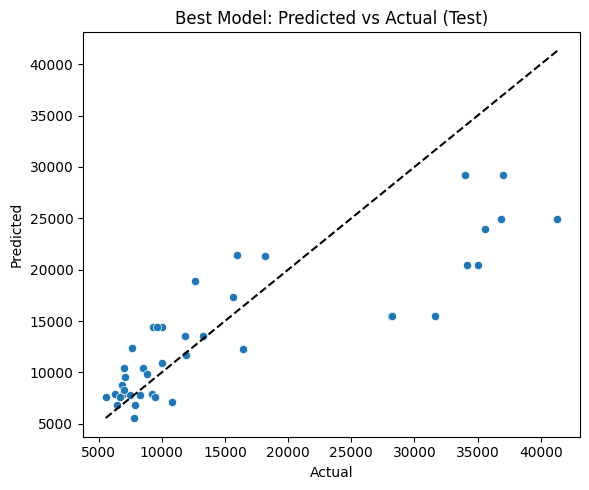

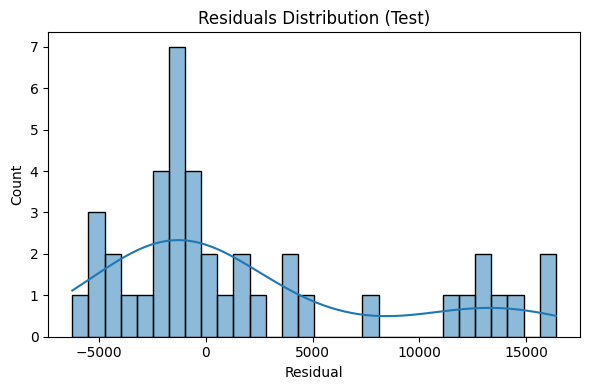

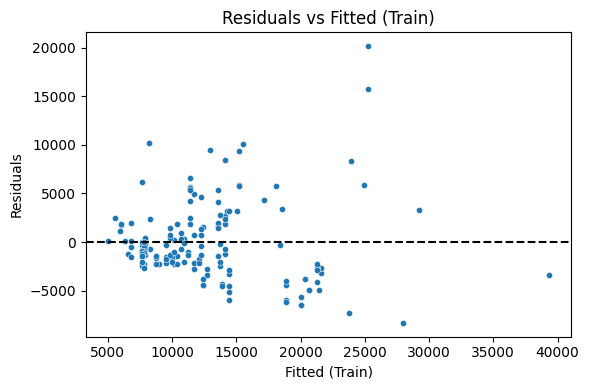

In [147]:
# Fit best model from GridSearchCV
best_model = grid.best_estimator_
best_model.fit(X_train, y_train)
y_pred_test = best_model.predict(X_test)
y_pred_train = best_model.predict(X_train)

# 1) Predicted vs Actual (Test)
plt.figure(figsize=(6, 5))
sns.scatterplot(x=y_test, y=y_pred_test, s=35)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Best Model: Predicted vs Actual (Test)')
plt.tight_layout()
plt.show()

# 2) Residuals distribution (Test)
residuals = y_test - y_pred_test
plt.figure(figsize=(6, 4))
sns.histplot(residuals, kde=True, bins=30)
plt.title('Residuals Distribution (Test)')
plt.xlabel('Residual')
plt.tight_layout()
plt.show()

# 3) Residuals vs Fitted (Train)
residuals_train = y_train - y_pred_train
plt.figure(figsize=(6, 4))
sns.scatterplot(x=y_pred_train, y=residuals_train, s=20)
plt.axhline(0, color='k', linestyle='--')
plt.xlabel('Fitted (Train)')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted (Train)')
plt.tight_layout()
plt.show()

# Final Conclusion
- A simple linear baseline using one strong feature provides a quick benchmark.
- Polynomial expansion improves fit up to an optimal degree; beyond that it overfits.
- Ridge regularization stabilizes the model and improves generalization when tuned.
- Grid search selects robust degree/alpha; visuals show reasonable calibration and residual behavior.
- Next: extend features (multi-variable), add standardization, and evaluate with train/validation/test splits.

In [148]:
!jupyter nbconvert --to pdf --output "05_model_evaluation_and_Refinement_cars.pdf" "05_model_evaluation_and_Refinement_cars.ipynb"

[NbConvertApp] Converting notebook 05_model_evaluation_and_Refinement_cars.ipynb to pdf
[NbConvertApp] Support files will be in 05_model_evaluation_and_Refinement_cars_files\
[NbConvertApp] Making directory .\05_model_evaluation_and_Refinement_cars_files
[NbConvertApp] Writing 54608 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | b had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 267941 bytes to 05_model_evaluation_and_Refinement_cars.pdf
